# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import idct, dct
from pathlib import Path
sns.set(font_scale=1.3)
# path = './drive/My Drive/Colab Notebooks/Analysis/sentences_express_predictions/'
# all_files = glob.glob(os.path.join(path, "*.npy"))
# for file in all_files[60:63]:
#   preds = np.load(file,allow_pickle=True)
#   print(preds[100])

# path = './drive/My Drive/Colab Notebooks/Analysis/sentences/'
# all_files = glob.glob(os.path.join(path, "*.txt"))
# for filename in all_files[60:63]:
#   with open(filename, "r", encoding='utf-8') as f:
#       sentences = f.read().splitlines()
#       print(sentences[100])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper funcs

In [40]:
x_label = 'Story Progress (%)'
y_label = 'Score'
def plot_dct(dim_name, df_dct):
  fig = plt.figure()
  ax = sns.lineplot(x="s_index", y=dim_name, data=df_dct)
  ax.set_title('DCT')
  # ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  fig.set_size_inches(8,4)
  plt.show()

def plot_dct_all(dim_names, df_dcts):
  fig = plt.figure()
  # labels = ['Love', 'Wow', 'Haha', 'Sad', 'Angry']
  labels = ['V', 'A', 'D']
  for index, df_dct in enumerate(df_dcts):
    ax = sns.lineplot(x="s_index", y=dim_names[index], data=df_dct)
  ax.set_title('DCT')
  plt.legend(title='Reaction', labels=labels,loc='center right',
          ncol=1,fontsize='small')
  # ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  fig.set_size_inches(8,4)
  plt.show()

def plot_rm(dim_name, df_rm):
  fig = plt.figure()
  ax = sns.lineplot(x="s_index", y=dim_name, data=df_rm)
  ax.set_title('Rolling Average')
  # ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  fig.set_size_inches(8,4)
  plt.show()

def plot_bin(dim_name, df_bin):
  fig = plt.figure()
  ax = sns.lineplot(x="s_index", y=dim_name, data=df_bin)
  ax.set_title('Binning')
  # ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  fig.set_size_inches(8,4)
  plt.show()

def plot_og(dim_name, df_og):
  fig = plt.figure()
  shape = df_og.shape
  print(shape)
  # ax = sns.lineplot(x="s_index", y=dim_name, data=df_og)
  ax = sns.regplot(x="s_index", y=dim_name, data=df_og, lowess=True, line_kws={'color': 'red'}, scatter_kws={"s": 1, 'alpha': 0, 'color': 'lightblue'})
  ax.set_title('LOWESS')
  # ax.set_title('Raw')
  # ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  
  fig.set_size_inches(8,4)
  plt.show()

def plot_all(dim_name, df_og, df_rm, df_dct):
  fig = plt.figure()
  ax = sns.lineplot(x="s_index", y=dim_name, data=df_dct)
  # ax = sns.lineplot(x="s_index", y=dim_name, data=df_og)
  ax = sns.lineplot(x="s_index", y=dim_name, data=df_rm)
  # ax = sns.regplot(x="s_index", y=dim_name, data=df_og, lowess=True, line_kws={'color': 'red'}, scatter_kws={"s": 1, 'alpha': 0, 'color': 'lightblue'})
  ax.set_title('%s vs. %s' % (y_label, x_label))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  fig.set_size_inches(8,4)
  plt.show()


In [4]:
def series_to_df(series):
  df = pd.DataFrame(series)
  df = df.rename(columns={0: dim_name})
  df['s_index'] = df.index

  return df

def rescale(s):
  return (s - min(s))/( max(s) - min(s))
  # return 2 * (s - min(s))/( max(s) - min(s)) -1


def compute_series_rm(dim_preds, window):
  series = pd.Series(dim_preds)
  series_rm = series.rolling(window).mean()
  # series_rm = rescale(series_rm)
  return series_rm

def compute_series_og(dim_preds):
  series_og = pd.Series(dim_preds)
  # series_og = rescale(series_og)
  return series_og

def compute_series_dct(dim_preds, x_reverse_len, low_pass_size, scale_y):
  series = pd.Series(dim_preds)
  series_dct = series.values
  series_dct = dct(series_dct)
  
  if series_dct.shape[0] < low_pass_size:
    print('here %s' % series_dct.shape)
    keepers = np.zeros(low_pass_size)
    keepers[0:series_dct.shape[0]] = series_dct[0:series_dct.shape[0]]
  else:
    keepers = np.zeros(low_pass_size)
    keepers[0:low_pass_size] = series_dct[0:low_pass_size]
  
  padded_keepers = np.zeros(x_reverse_len)
  padded_keepers[0:low_pass_size] = keepers
  # padded_keepers = np.concatenate((keepers, np.zeros(x_reverse_len-low_pass_size)))
  series_dct = idct(padded_keepers)
  # print(series_dct.shape)

  if scale_y:
    series_dct = rescale(series_dct)
  
  return series_dct


# Transform raw predictions

LPS: 4 Dim: V
['./drive/My Drive/Colab Notebooks/Analysis/guten/sentences_express_predictions/2413.npy']
LPS: 4 Dim: A
['./drive/My Drive/Colab Notebooks/Analysis/guten/sentences_express_predictions/2413.npy']
LPS: 4 Dim: D
['./drive/My Drive/Colab Notebooks/Analysis/guten/sentences_express_predictions/2413.npy']


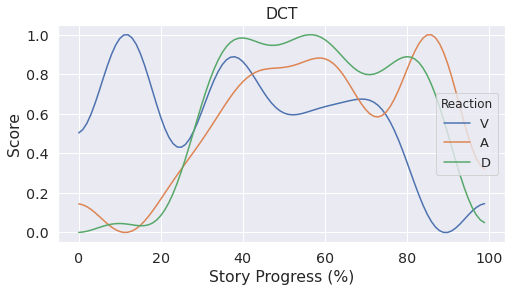

In [41]:


# paths = []
path = './drive/My Drive/Colab Notebooks/Analysis/guten/sentences_express_predictions/'
# path = './drive/My Drive/Colab Notebooks/Analysis/guten/sentences_react_predictions/'

# path = './drive/My Drive/Colab Notebooks/Analysis/scripts/sentences_react_predictions/'
# paths.append('./drive/My Drive/Colab Notebooks/Analysis/sentences_react_vad_predictions/')
dct_active = True
rm_active = False
og_active = False

low_pass_sizes = list(range(4,5))
# low_pass_sizes = list(range(2,16))
dims = ['V', 'A', 'D']
# dims = ['love_count']
# dims = ['love_count','wow_count','haha_count','sad_count','angry_count']
df_dcts = []
for low_pass_size in low_pass_sizes:
  for dim_ix, dim_name in enumerate(dims):
    print('LPS:', low_pass_size, 'Dim:', dim_name, sep=" ")

    all_files = glob.glob(os.path.join(path, "2413.npy"))
    # all_files = glob.glob(os.path.join(path, "*.npy"))

    all_series_dct = []
    all_series_rm = []
    all_series_og = []

    print(all_files)
    for file_ix, file in enumerate(all_files):
      basename = os.path.basename(file)
      fileID = os.path.splitext(basename)[0]
      preds = np.load(file,allow_pickle=True)

      dim_vals = preds[:,dim_ix]

      if rm_active:
        series_rm = compute_series_rm(dim_vals, 1000)
        all_series_rm.append(series_rm)
        df_rm = series_to_df(series_rm)

      if og_active:
        series_og = compute_series_og(dim_vals)
        all_series_og.append(series_og)
        df_og = series_to_df(series_og)
      
      if dct_active:
        series_dct = compute_series_dct(dim_vals, 100, 10, True)
        all_series_dct.append(series_dct)
        df_dct = series_to_df(series_dct)
      
      df_dcts.append(df_dct)

      if False:
        df_bin = series_to_df(series_og)
        # print(df_bin)
        # Bin the data frame by "a" with 10 bins...
        groups = df_bin.groupby(pd.cut(df_bin['s_index'], 10))
        # Get the mean of b, binned by the values in a
        groups = groups.mean().love_count
        groups = groups.values
        df_bin = series_to_df(groups)

      if False:
      # if file_ix % 100 == 0:
        print('File index: ', file_ix, 'Progress: ', file_ix / len(all_files) * 100)
        if True:
        # if file_ix % 1000 == 0:
          if False:
            df_rm['s_index'] = df_rm['s_index'] / df_rm.shape[0] * 100
            plot_rm(dim_name, df_rm)
          if False:
            df_og = df_rm
            df_og['s_index'] = df_og['s_index'] / df_og.shape[0] * 100
            plot_og(dim_name, df_og)
          if True:
            plot_dct(dim_name, df_dct)
          if False:
            df_bin['s_index'] = df_bin['s_index'] / df_bin.shape[0] * 100
            plot_bin(dim_name, df_bin)
          
          # plot_all(dim_name, df_og, df_rm, df_dct)
plot_dct_all(dims, df_dcts)
    # save_folder = 'dct/'
    # save_path = path + save_folder + dim_name 
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # save_path = save_path + '/' + str(low_pass_size) + '.npy'
    # print(save_path)
    # np.save(save_path, all_series_dct, allow_pickle=True)


# Dim reduction

In [ ]:
activate = True
path = "./drive/My Drive/Colab Notebooks/Analysis/guten/sentences_express_predictions"
trans = 'dct'
dim_name = 'V'
file = '10.npy'
X = np.load(path + '/' + trans+ '/' + dim_name + '/' + file,allow_pickle=True)
print(X.shape)
X = [x for x in X if np.any(np.isfinite(x))]
X = np.array(X)
print(X.shape)
# print(X[:10])

(1724, 100)
(1724, 100)


## PCA

Explained variation per principal component: [0.17829844 0.1561022  0.11200362]


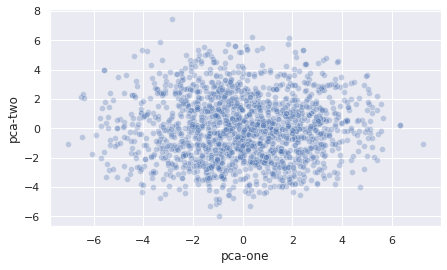

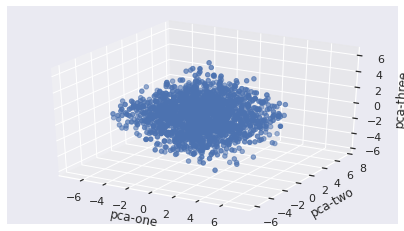

In [ ]:
if activate:
  import time
  from sklearn.decomposition import PCA
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  import seaborn as sns

  # data = np.array(X)
  # print(data.shape)
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(X)
  pca_df = pd.DataFrame()
  pca_df['pca-one'] = pca_result[:,0]
  pca_df['pca-two'] = pca_result[:,1] 
  pca_df['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  plt.figure(figsize=(7,4))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      # hue="y",
      palette=sns.color_palette("hls", 10),
      data=pca_df,
      legend="full",
      alpha=0.3
  )

  ax = plt.figure(figsize=(7,4)).gca(projection='3d')
  ax.scatter(
      xs=pca_df["pca-one"], 
      ys=pca_df["pca-two"], 
      zs=pca_df["pca-three"], 
      # c=pca_df.loc[rndperm,:]["y"], 
      cmap='tab10'
  )
  ax.set_xlabel('pca-one')
  ax.set_ylabel('pca-two')
  ax.set_zlabel('pca-three')
  plt.show()

## TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1724 samples in 0.018s...
[t-SNE] Computed neighbors for 1724 samples in 0.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1724
[t-SNE] Computed conditional probabilities for sample 1724 / 1724
[t-SNE] Mean sigma: 1.995060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.033752
[t-SNE] KL divergence after 300 iterations: 2.176976


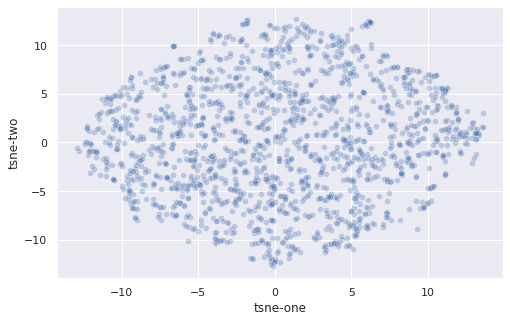

In [ ]:
if activate:
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(X)

  tsne_df = pd.DataFrame()
  tsne_df['tsne-one'] = tsne_results[:,0]
  tsne_df['tsne-two'] = tsne_results[:,1]
  # tsne_df['tsne-three'] = tsne_results[:,2]

  plt.figure(figsize=(8,5))
  sns.scatterplot(
      x="tsne-one", y="tsne-two",
      # hue="y",
      palette=sns.color_palette("hls", 10),
      data=tsne_df,
      legend="full",
      alpha=0.3
  )

  # ax = plt.figure(figsize=(8,5)).gca(projection='3d')
  # ax.scatter(
  #     xs=tsne_df["tsne-one"], 
  #     ys=tsne_df["tsne-two"], 
  #     # zs=tsne_df["tsne-three"], 
  #     # c=tsne_df.loc[rndperm,:]["y"], 
  #     cmap='tab10'
  # )
  # ax.set_xlabel('tsne-one')
  # ax.set_ylabel('tsne-two')
  # # ax.set_zlabel('tsne-three')
  # plt.show()



## PCA-TSNE

In [ ]:
if activate:
  pca_50 = PCA(n_components=50)
  pca_result_50 = pca_50.fit_transform(X)
  print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
  tsne_pca_results = tsne.fit_transform(pca_result_50)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  tsne_pca_df = pd.DataFrame()
  tsne_pca_df['tsne-pca50-one'] = tsne_pca_results[:,0]
  tsne_pca_df['tsne-pca50-two'] = tsne_pca_results[:,1]
  plt.figure(figsize=(8,5))

  # ax3 = plt.subplot(1, 3, 3)
  sns.scatterplot(
      x="tsne-pca50-one", y="tsne-pca50-two",
      # hue="y",
      palette=sns.color_palette("hls", 10),
      data=tsne_pca_df,
      legend="full",
      alpha=0.3
      # ax=ax3
  )



# Determine num clusters

In [ ]:
activate = True
path = "./drive/My Drive/Colab Notebooks/Analysis/scripts/sentences_express_predictions"
trans = 'dct'
dim_name = 'A'
file = '5.npy'
X = np.load(path + '/' + trans+ '/' + dim_name + '/' + file,allow_pickle=True)
print(X.shape)
X = [x for x in X if np.any(np.isfinite(x))]
X = np.array(X)
print(X.shape)
# print(X[:10])
# X=tsne_df

(1120, 100)
(1066, 100)


## Elbow method

In [ ]:
if activate:
  from sklearn.cluster import KMeans, DBSCAN

  Sum_of_squared_distances = []
  K = range(1,50)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(X)
      
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

## Gap statistic

In [ ]:
!pip install --upgrade gap-stat
from gap_statistic import OptimalK
import numpy as np
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
n_clusters = optimalK(X, cluster_array=np.arange(1, 50))
print(X.shape)

(1066, 100)


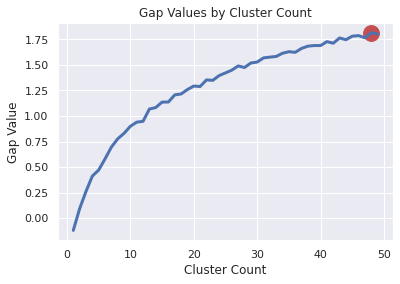

In [ ]:
optimalK.gap_df.head()
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


In [ ]:
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 50
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(), X, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

## Silhoutte method

In [ ]:
if activate:
  from sklearn.datasets import make_blobs
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score
  from sklearn.cluster import AgglomerativeClustering

  import matplotlib.pyplot as plt
  import matplotlib.cm as cm
  import numpy as np

  range_n_clusters = list(range(2,50))
  silhouette_avgs = []
  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, ax1 = plt.subplots(1)
      fig.set_size_inches(9, 4)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      # clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      clusterer = AgglomerativeClustering(n_clusters=n_clusters)
      cluster_labels = clusterer.fit_predict(X)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)
      silhouette_avgs.append(silhouette_avg)

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # # 2nd Plot showing the actual clusters formed
      # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
      #             c=colors, edgecolor='k')

      # # Labeling the clusters
      # centers = clusterer.cluster_centers_
      # # Draw white circles at cluster centers
      # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
      #             c="white", alpha=1, s=200, edgecolor='k')

      # for i, c in enumerate(centers):
      #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
      #                 s=50, edgecolor='k')

      # ax2.set_title("The visualization of the clustered data.")
      # ax2.set_xlabel("Feature space for the 1st feature")
      # ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()
  
  ax = sns.lineplot(data=pd.DataFrame(silhouette_avgs))

Output hidden; open in https://colab.research.google.com to view.

# Clustering

In [ ]:
activate = True
path = "./drive/My Drive/Colab Notebooks/Analysis/guten/sentences_react_predictions"
trans = 'dct'
dim_name = 'love_count'
file = '3.npy'
# X = tsne_df
X = np.load(path + '/' + trans+ '/' + dim_name + '/' + file,allow_pickle=True)
print(X.shape)
X = [x for x in X if np.any(np.isfinite(x))]
X = np.array(X)
print(X.shape)
# print(X[:10])

FileNotFoundError: ignored

In [ ]:
# !pip install fastdtw
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def fastdtw_matrix(X):
  dist = lambda x, y: fastdtw(x, y,dist=euclidean)

  dm = np.asarray([[dist(p1, p2) for p2 in X] for p1 in X])
  return dm

print(fastdtw_matrix(X))

def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

KeyboardInterrupt: ignored

K means

## Hierarchical

In [ ]:
if activate:
  from sklearn.cluster import AgglomerativeClustering
  from sklearn.metrics.pairwise import pairwise_distances
  
  metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
  # dist_matrix = pairwise_distances(X, X, metrics[2])
  # print(dist_matrix.shape)
  clustering = AgglomerativeClustering(n_clusters=6).fit(X)
  # clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(dist_matrix)
  labels = clustering.labels_
  cluster_ids = set(labels)
  print(cluster_ids)

{0, 1, 2, 3, 4, 5}


### Find cut 

In [ ]:
def calculate_homogeneity(euc_distance_to_centroids):
  SSW = np.sum(euc_distance_to_centroids**2)
  return SSW
def calculate_dissimilarity(X,euc_distance_to_centroids):
  TSS = np.sum((X-X.mean(0))**2)
  SSB = TSS - calculate_homogeneity(euc_distance_to_centroids)
  return SBB

import numpy as np
from scipy.cluster.vq import vq

# X = np.array([[ 2.,  4.,  2.],
#               [ 1.,  3.,  1.],
#               [ 3.,  4.,  2.],
#               [ 2.,  3.,  2.],
#               [ 1.,  5.,  5.]])

codebook = np.array([[ 1.  ,  3.  ,  1.  ],
                     [ 2.33,  3.67,  2.  ],
                     [ 1.  ,  5.  ,  5.  ]])

partition, euc_distance_to_centroids = vq(X, codebook)
print(calculate_homogeneity(euc_distance_to_centroids))

ValueError: ignored

In [ ]:
for k in range(2, 51):
  # - cut the tree such that there are K clusters
  clustering = AgglomerativeClustering(n_clusters=k).fit(dist_matrix)
  # - calculate the amount of in-cluster homogeneity
  labels = clustering.labels_
  cluster_ids = set(labels)
  for c_id in cluster_ids:
    matches = labels == c_id
    matching_series = X[matches]
    
  # - calculate the dissimilarity between the K clusters


### Dendrogram

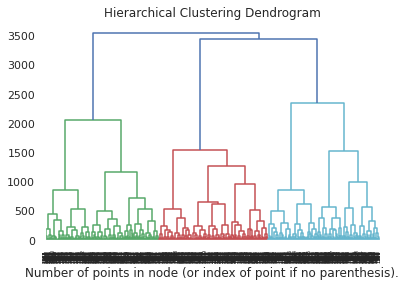

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode=None, p=3)
# plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## HDBSCAN

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2308866 sha256=60ab1ed28049ddcf6cefeb2d5372afcf694591f498eb63fc8f724f2756124868
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [ ]:
if activate:
  from hdbscan import HDBSCAN
  from sklearn.metrics.pairwise import pairwise_distances
  import fastdtw
  metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
  dist_matrix = pairwise_distances(X, X, metrics[2])
  print(dist_matrix.shape)
  clustering = HDBSCAN(metric='euclidean', min_cluster_size=20, min_samples=5).fit(X)
  labels = clustering.labels_
  cluster_ids = set(labels)
  print(cluster_ids)


(1066, 1066)
{0, 1, 2, 3, 4, 5, -1}


## Draw clusters

In [ ]:
activate_scatter = True
activate_arcs = True

### Scatter

In [ ]:
if activate:
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  # tsne_results = tsne.fit_transform(X)
  print(X.shape)
  tsne_df = pd.DataFrame()
  tsne_df['tsne-one'] = X.iloc[:,0]
  tsne_df['tsne-two'] = X.iloc[:,1]
  tsne_df['y'] = np.array(labels)
  print(tsne_df.shape)
  print(tsne_df.head())
      
  plt.figure(figsize=(8,5))

  sns.scatterplot(
      x="tsne-one", y="tsne-two",
      hue="y",
      palette=sns.color_palette("hls", 10),
      data=tsne_df,
      legend="full",
      alpha=0.3
      # ax=ax3
  )
  plt.show()

(1724, 2)


ValueError: ignored

### Arcs

(100, 2)
(28600, 2)


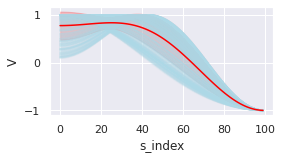

(100, 2)
(17600, 2)


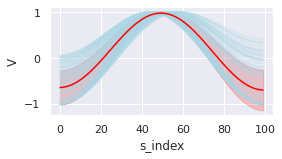

(100, 2)
(26000, 2)


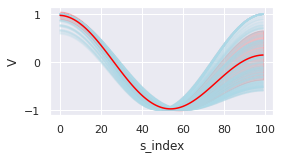

(100, 2)
(9800, 2)


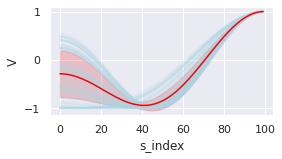

(100, 2)
(18300, 2)


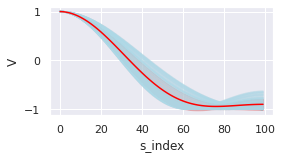

(100, 2)
(6300, 2)


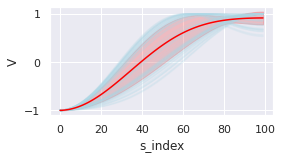

In [ ]:
if activate:
  for c_id in cluster_ids:
    fig = plt.figure()
    matches = labels == c_id
    matching_series = X[matches]

    all_df = series_to_df(matching_series[0])
    print(all_df.shape)
    for series in matching_series[1:]:
      df = series_to_df(series)
      ax = sns.lineplot(x="s_index", y=dim_name, data=df, alpha= 0.2, color= 'lightblue')
      
      all_df = pd.concat([all_df, df])
    print(all_df.shape)
    # ax = sns.regplot(x="s_index", y=dim_name, data=all_df, lowess=False, scatter=False)
    ax = sns.lineplot(x="s_index", y=dim_name, data=all_df, alpha= 1, ci='sd',color= 'red')

    fig.set_size_inches(4,2)
    plt.show()
  
# df = tsne_df
# print(df.shape)
# for c_id in cluster_ids:
#   fig = plt.figure()

#   curr_df = df[df['y'] == c_id]
#   ax = sns.lineplot(x="s_index", y=dim_name, data=curr_df, alpha= 1, ci='sd',color= 'red')

#   fig.set_size_inches(4,2)
#   plt.show()


# SOM

In [ ]:
# !pip install minisom
activate = False

path = "./drive/My Drive/Colab Notebooks/Analysis/sentences_express_predictions"
trans = 'dct'
dim_name = 'V'
file = '5.npy'
X = np.load(path + '/' + trans+ '/' + dim_name + '/' + file,allow_pickle=True)

In [ ]:
from minisom import MiniSom    
print(X.shape)
som = MiniSom(8, 8, 100, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train(X, 100) # trains the SOM with 100 iterations

som.winner(X[0])


(1724, 100)
<bound method MiniSom.win_map of <minisom.MiniSom object at 0x7f1f5785ddd8>>


NameError: ignored

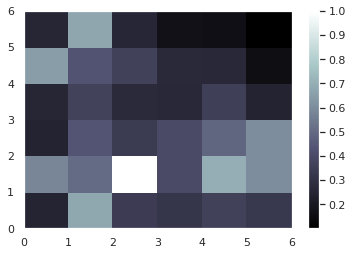

In [ ]:
# from pylab import plot,axis,show,pcolor,colorbar,bone
# bone()
# pcolor(som.distance_map().T) # distance map as background
# colorbar()
# # loading the labels
# # target = genfromtxt('iris.csv',
# #                     delimiter=',',usecols=(4),dtype=str)
# # t = zeros(len(target),dtype=int)
# # t[target == 'setosa'] = 0
# # t[target == 'versicolor'] = 1
# # t[target == 'virginica'] = 2
# # use different colors and markers for each label
# markers = ['o','s','D']
# colors = ['r','g','b']
# for cnt,xx in enumerate(X):
#  w = som.winner(xx) # getting the winner
#  # palce a marker on the winning position for the sample xx
#  plot(w[0]+.5,w[1]+.5,,markerfacecolor='None',
#    markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
# axis([0,som.weights.shape[0],0,som.weights.shape[1]])
# show() # show the figure